### Hyperparameter Tuning for Early Diagnosis of Parkinson’s Disease Using Big Data


Harshini Raju (hr2457), Manali Tanna (mut8188), Kurapati Aravind (ksa9148)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Parkinsons Dataset Processing") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 18:24:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql import functions as F

In [3]:
# Define the path for the data
path = 'content/'

# Dictionary containing file names and columns for each dataset
file_paths = {
    "pat_status": "Patient_Status-Archived_21Apr2024.csv",
    "pat_demographics": "Screening___Demographics-Archived_21Apr2024.csv",
    "pat_family_history": "Family_History__PD_-Archived_21Apr2024.csv",
    "updrs1": "MDS-UPDRS_Part_I_21Apr2024.csv",
    "updrs1pq": "MDS-UPDRS_Part_I_Patient_Questionnaire_21Apr2024.csv",
    "updrs2pq": "MDS_UPDRS_Part_II__Patient_Questionnaire_21Apr2024.csv",
    "updrs3": "MDS-UPDRS_Part_III_21Apr2024.csv",
    "moca": "Montreal_Cognitive_Assessment__MoCA__21Apr2024.csv",
    "stai": "State-Trait_Anxiety_Inventory_21Apr2024.csv",
    "gds": "Geriatric_Depression_Scale__Short_Version__21Apr2024.csv",
    "quip": "QUIP-Current-Short_21Apr2024.csv",
    "scopa_aut": "SCOPA-AUT_21Apr2024.csv",
    "sft": "Semantic_Fluency-Archived_21Apr2024.csv",
    "rem_rbd": "REM_Sleep_Behavior_Disorder_Questionnaire_21Apr2024.csv",
    "epworth": "Epworth_Sleepiness_Scale_21Apr2024.csv",
    "hvlt": "Hopkins_Verbal_Learning_Test_-_Revised_21Apr2024.csv",
    "lns": "Letter_-_Number_Sequencing_21Apr2024.csv",
    "neuro_cranial": "Neurological_Exam_-_Cranial_Nerves-Archived_21Apr2024.csv",
    "sdm": "Symbol_Digit_Modalities_Test_21Apr2024.csv",
    "benton": "Benton_Judgement_of_Line_Orientation_21Apr2024.csv"
}

In [4]:

# Dictionary to map each data set to its respective columns needed for analysis
# Dictionary to hold DataFrame names and their corresponding column names
covariates = {
    "pat_status": ["PATNO", "RECRUITMENT_CAT", "IMAGING_CAT", "ENROLL_DATE", "ENROLL_CAT"],
    "pat_demographics": ["PATNO", "BIRTHDT", "GENDER", "APPRDX", "CURRENT_APPRDX", "HISPLAT", "RAINDALS", "RAASIAN", "RABLACK", "RAHAWOPI", "RAWHITE", "RANOS"],
    "pat_family_history": ["PATNO", "BIOMOMPD", "BIODADPD", "FULSIBPD", "HAFSIBPD", "MAGPARPD", "PAGPARPD", "MATAUPD", "PATAUPD", "KIDSPD"],
    "updrs1": ["PATNO", "EVENT_ID", "INFODT", "NP1COG", "NP1HALL", "NP1DPRS", "NP1ANXS", "NP1APAT", "NP1DDS"],
    "updrs1pq": ["PATNO", "EVENT_ID", "NP1SLPN", "NP1SLPD", "NP1PAIN", "NP1URIN", "NP1CNST", "NP1LTHD", "NP1FATG"],
    "updrs2pq": ["PATNO", "EVENT_ID", "NP2SPCH", "NP2SALV", "NP2SWAL", "NP2EAT", "NP2DRES", "NP2HYGN", "NP2HWRT", "NP2HOBB", "NP2TURN", "NP2TRMR", "NP2RISE", "NP2WALK", "NP2FREZ"],
    "updrs3": ["PATNO", "EVENT_ID", "PAG_NAME", "EXAMTM", "NP3SPCH", "NP3FACXP", "NP3RIGN", "NP3RIGRU", "NP3RIGLU", "NP3RIGLL", "NP3FTAPR", "NP3FTAPL", "NP3HMOVR", "NP3HMOVL", "NP3PRSPR", "NP3PRSPL", "NP3TTAPR", "NP3TTAPL", "NP3LGAGR", "NP3LGAGL", "NP3RISNG", "NP3GAIT", "NP3FRZGT", "NP3PSTBL", "NP3POSTR", "NP3BRADY", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", "NP3RTALJ", "NP3RTCON", "DYSKPRES", "DYSKIRAT", "NHY"],
    "moca": ["PATNO", "EVENT_ID", "MCAALTTM", "MCACUBE", "MCACLCKC", "MCACLCKN", "MCACLCKH", "MCALION", "MCARHINO", "MCACAMEL", "MCAFDS", "MCABDS", "MCAVIGIL", "MCASER7", "MCASNTNC", "MCAVFNUM", "MCAVF", "MCAABSTR", "MCAREC1", "MCAREC2", "MCAREC3", "MCAREC4", "MCAREC5", "MCADATE", "MCAMONTH", "MCAYR", "MCADAY", "MCAPLACE", "MCACITY", "MCATOT"],
    "stai": ["PATNO", "EVENT_ID", "STAIAD1", "STAIAD2", "STAIAD3", "STAIAD4", "STAIAD5", "STAIAD6", "STAIAD7", "STAIAD8", "STAIAD9", "STAIAD10", "STAIAD11", "STAIAD12", "STAIAD13", "STAIAD14", "STAIAD15", "STAIAD16", "STAIAD17", "STAIAD18", "STAIAD19", "STAIAD20", "STAIAD21", "STAIAD22", "STAIAD23", "STAIAD24", "STAIAD25", "STAIAD26", "STAIAD27", "STAIAD28", "STAIAD29", "STAIAD30", "STAIAD31", "STAIAD32", "STAIAD33", "STAIAD34", "STAIAD35", "STAIAD36", "STAIAD37", "STAIAD38", "STAIAD39", "STAIAD40"],
    "gds": ["PATNO", "EVENT_ID", "GDSSATIS", "GDSDROPD", "GDSEMPTY", "GDSBORED", "GDSGSPIR", "GDSAFRAD", "GDSHAPPY", "GDSHLPLS", "GDSHOME", "GDSMEMRY", "GDSALIVE", "GDSWRTLS", "GDSENRGY", "GDSHOPLS", "GDSBETER"],
    "quip": ["PATNO", "EVENT_ID", "TMGAMBLE", "CNTRLGMB", "TMSEX", "CNTRLSEX", "TMBUY", "CNTRLBUY", "TMEAT", "CNTRLEAT", "TMTORACT", "TMTMTACT", "TMTRWD"],
    "scopa_aut": ["PATNO", "EVENT_ID", "SCAU1", "SCAU2", "SCAU3", "SCAU4", "SCAU5", "SCAU6", "SCAU7", "SCAU8", "SCAU9", "SCAU10", "SCAU11", "SCAU12", "SCAU13", "SCAU14", "SCAU15", "SCAU16", "SCAU17", "SCAU18", "SCAU19", "SCAU20", "SCAU21", "SCAU22", "SCAU23", "SCAU23A", "SCAU23AT", "SCAU24", "SCAU25", "SCAU26A", "SCAU26AT", "SCAU26B", "SCAU26BT", "SCAU26C", "SCAU26CT", "SCAU26D", "SCAU26DT"],
    "sft": ["PATNO", "EVENT_ID", "VLTANIM", "VLTVEG", "VLTFRUIT"],
    "rem_rbd": ["PATNO", "EVENT_ID", "DRMVIVID", "DRMAGRAC", "DRMNOCTB", "SLPLMBMV", "SLPINJUR", "DRMVERBL", "DRMFIGHT", "DRMUMV", "DRMOBJFL", "MVAWAKEN", "DRMREMEM", "SLPDSTRB", "STROKE", "HETRA", "RLS", "NARCLPSY", "DEPRS", "EPILEPSY", "BRNINFM"],
    "epworth": ["PATNO", "EVENT_ID", "ESS1", "ESS2", "ESS3", "ESS4", "ESS5", "ESS6", "ESS7", "ESS8"],
    "hvlt": ["PATNO", "EVENT_ID", "HVLTRT1", "HVLTRT2", "HVLTRT3", "HVLTRDLY", "HVLTREC", "HVLTFPRL", "HVLTFPUN"],
    "lns": ["PATNO", "EVENT_ID", "LNS_TOTRAW"],
    "neuro_cranial": ["PATNO", "EVENT_ID", "CN1RSP", "CN2RSP", "CN346RSP", "CN5RSP", "CN7RSP", "CN8RSP", "CN910RSP", "CN11RSP", "CN12RSP"],
    "sdm": ["PATNO", "EVENT_ID", "SDMTOTAL"],
    "benton": ["PATNO", "EVENT_ID", "JLO_TOTRAW"]
}


In [5]:
# Function to read a dataset into a DataFrame using specified columns
def read_dataset(name):
    df = spark.read.csv(path + file_paths[name], header=True).select(covariates[name])
    if "EVENT_ID" in covariates[name]:
        df = df.filter(df["EVENT_ID"].isin(['BL', 'V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12']))
    df.createOrReplaceTempView(name)  # Register DataFrame as a temporary table
    return df

# Reading datasets and registering them with Spark
pat_status = read_dataset("pat_status")
pat_demographics = read_dataset("pat_demographics")
pat_family_history = read_dataset("pat_family_history")
updrs1 = read_dataset("updrs1")
updrs1pq = read_dataset("updrs1pq")
updrs2pq = read_dataset("updrs2pq")
updrs3_temp = read_dataset("updrs3")

# Handling specific filtering for UPDRS3
updrs3 = updrs3_temp.filter(updrs3_temp.PAG_NAME == 'NUPDRS3')  # Pre-med dose
updrs3a = updrs3_temp.filter(updrs3_temp.PAG_NAME == 'NUPDRS3A')  # Post-med dose

moca = read_dataset("moca")
stai = read_dataset("stai")
gds = read_dataset("gds")
quip = read_dataset("quip")
scopa_aut = read_dataset("scopa_aut")
sft = read_dataset("sft")
rem_rbd = read_dataset("rem_rbd")
epworth = read_dataset("epworth")
hvlt = read_dataset("hvlt")
lns = read_dataset("lns")
neuro_cranial = read_dataset("neuro_cranial")
sdm = read_dataset("sdm")
benton = read_dataset("benton")


24/05/06 18:24:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
# Define a function for time series vectorization and imputation
def vectorize_and_impute(df):
    df = df.drop('INFODT')  # Drop unwanted column
    df = df.groupBy('PATNO', 'EVENT_ID').pivot('EVENT_ID').agg(F.first(*df.columns[2:]))
    # Interpolate missing values using linear function
    for col in df.columns[2:]:
        df = df.withColumn(col, F.coalesce(df[col], F.last(df[col], ignorenulls=True).over(Window.partitionBy('PATNO').orderBy('EVENT_ID'))))
    return df

In [7]:
# List of datasets for analysis
list_of_datasets = ['updrs1', 'updrs1pq', 'updrs2pq', 'updrs3', 'moca', 'stai', 'gds', 'quip', 'scopa_aut', 
            'sft', 'rem_rbd', 'epworth', 'hvlt', 'lns', 'neuro_cranial', 'sdm', 'benton']


In [8]:
# Define visits of interest and last visit
visit_ids_of_interest = ['BL', 'V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12']
last_visit = visit_ids_of_interest[-1]  # V12

# Initialize DataFrame with PATNOs from the first dataset who were present at the last visit
initial_patnos = spark.table(list_of_datasets[0]).filter(F.col("EVENT_ID") == last_visit).select("PATNO").distinct()

# Intersect with PATNOs from other datasets who also were present at the last visit
for dataset in list_of_datasets:
    dataset_df = spark.table(dataset)
    patnos = dataset_df.filter(F.col("EVENT_ID") == last_visit).select("PATNO").distinct()
    initial_patnos = initial_patnos.join(patnos, "PATNO", "inner")

# Count of patients who participated till the last visit for all assessments
total_patients = initial_patnos.count()
print(f'Total {total_patients} number of patients who participated till last visit for all assessments')

# Constructing the merged_data dictionary with filtered data
merged_data = {}

Total 573 number of patients who participated till last visit for all assessments


In [9]:
# Filter the 'pat_status' DataFrame for PATNOs in 'initial_patnos'
status = spark.table("pat_status").join(initial_patnos, "PATNO")

In [10]:
# Alternatively, if you need to filter multiple tables based on the PATNOs from 'initial_patnos', use a semi-join:
demographics = spark.table("pat_demographics").join(initial_patnos, "PATNO", "inner")


In [11]:
# Merging 'status' and 'demographics' DataFrames
merged_info = status.join(demographics, "PATNO")
merged_data["info"] = merged_info

In [12]:
from pyspark.sql.functions import col

In [13]:
# Filter each dataset for the patients of interest and the visits of interest using joins
for dataset in list_of_datasets:
    dataset_df = spark.table(dataset)
    # Join with initial_patnos to filter by PATNO
    filtered_by_patno = dataset_df.join(initial_patnos, "PATNO")
    # Filter by EVENT_ID after joining
    filtered_by_event = filtered_by_patno.filter(col("EVENT_ID").isin(visit_ids_of_interest))
    merged_data[dataset] = filtered_by_event

In [14]:
merged_data["info"].groupBy("ENROLL_CAT").count().show()

+----------+-----+
|ENROLL_CAT|count|
+----------+-----+
|        PD|  308|
|     GENUN|   28|
|        HC|  154|
|  PRODROMA|   32|
|     REGPD|    1|
|     GENPD|   47|
|     SWEDD|    3|
+----------+-----+



In [15]:
# Assuming 'merged_data["info"]' has a column 'ENROLL_CAT' and is already prepared
enroll_cat_counts = merged_data["info"].groupBy("ENROLL_CAT").count()

In [16]:
# Convert to Pandas DataFrame for Plotting
enroll_cat_counts_pd = enroll_cat_counts.toPandas()
enroll_cat_counts_pd.sort_values("ENROLL_CAT", inplace=True)  # Sorting if needed


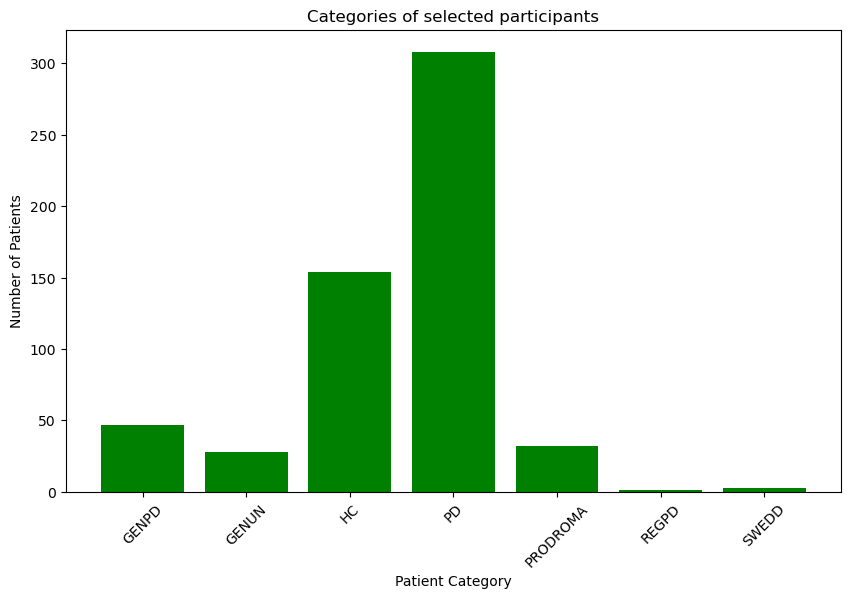

In [17]:
import matplotlib.pyplot as plt

# Define colors based on the categories, you might need to adjust this based on actual categories
colors = ['r' if 'high' in cat else 'g' for cat in enroll_cat_counts_pd['ENROLL_CAT']]

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(enroll_cat_counts_pd['ENROLL_CAT'], enroll_cat_counts_pd['count'], color=colors)
plt.title("Categories of selected participants")
plt.xlabel("Patient Category")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)  # Rotate category names for better visibility
plt.show()


In [18]:
from pyspark.sql.functions import col, when

# Replace gender codes with descriptive text
info_with_gender = merged_data["info"].withColumn(
    "GENDER",
    when(col("GENDER") == 0, "F bearing child")
    .when(col("GENDER") == 1, "F Normal")
    .when(col("GENDER") == 2, "M")
    .otherwise(col("GENDER"))  # You can add an otherwise if there are other codes or to handle unexpected values
)


In [19]:
gender_counts = info_with_gender.groupBy("GENDER").count()


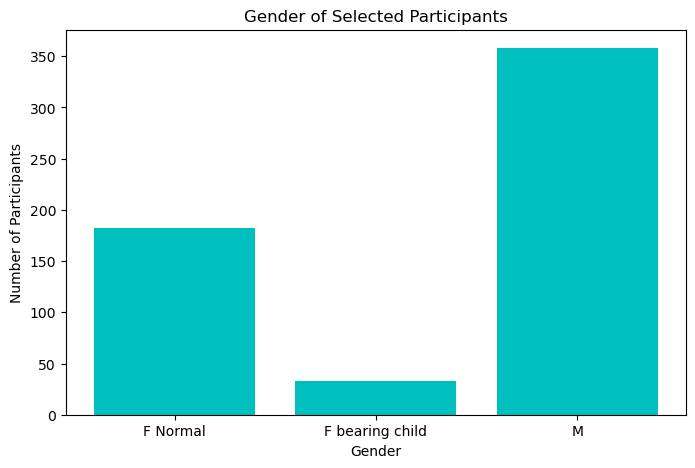

In [20]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
gender_counts_pd = gender_counts.toPandas()
gender_counts_pd.sort_values("GENDER", inplace=True)  # Sorting if there are multiple categories

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(gender_counts_pd['GENDER'], gender_counts_pd['count'], color='c')
plt.title("Gender of Selected Participants")
plt.xlabel("Gender")
plt.ylabel("Number of Participants")
plt.xticks(rotation=0)  # Set rotation for x-axis labels if needed
plt.show()


In [19]:
from pyspark.sql.functions import col, last, concat

In [20]:
# Assuming 'merged_data' has already been set with 'updrs1' data
d1 = merged_data['updrs1'].drop('INFODT')

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d1.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Initialize the pivot DataFrame by starting with the first column to establish the DataFrame structure
pivot_df1 = d1.groupBy('PATNO').pivot('EVENT_ID').agg(last(columns_to_pivot[0]).alias(columns_to_pivot[0]))
print(pivot_df1)
# Pivot each of the remaining columns and join them back to the initial pivot_df
for column in columns_to_pivot[1:]:
    temp_df = d1.groupBy('PATNO').pivot('EVENT_ID').agg(last(column).alias(column))
    pivot_df1 = pivot_df1.join(temp_df, on="PATNO", how="outer")


DataFrame[PATNO: string, BL: string, V01: string, V02: string, V03: string, V04: string, V05: string, V06: string, V07: string, V08: string, V09: string, V10: string, V11: string, V12: string]


In [21]:
from pyspark.sql.functions import last

# Assuming 'merged_data' is a DataFrame and 'updrs1' is a DataFrame within 'merged_data'
d1 = merged_data['updrs1'].drop('INFODT')  # Drop unwanted column

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d1.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df1 = d1.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# Print to inspect the initial pivot output
print(pivot_df1)

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df1 = pivot_df1.na.fill(0)

DataFrame[PATNO: string, BL_NP1COG: string, BL_NP1HALL: string, BL_NP1DPRS: string, BL_NP1ANXS: string, BL_NP1APAT: string, BL_NP1DDS: string, V01_NP1COG: string, V01_NP1HALL: string, V01_NP1DPRS: string, V01_NP1ANXS: string, V01_NP1APAT: string, V01_NP1DDS: string, V02_NP1COG: string, V02_NP1HALL: string, V02_NP1DPRS: string, V02_NP1ANXS: string, V02_NP1APAT: string, V02_NP1DDS: string, V03_NP1COG: string, V03_NP1HALL: string, V03_NP1DPRS: string, V03_NP1ANXS: string, V03_NP1APAT: string, V03_NP1DDS: string, V04_NP1COG: string, V04_NP1HALL: string, V04_NP1DPRS: string, V04_NP1ANXS: string, V04_NP1APAT: string, V04_NP1DDS: string, V05_NP1COG: string, V05_NP1HALL: string, V05_NP1DPRS: string, V05_NP1ANXS: string, V05_NP1APAT: string, V05_NP1DDS: string, V06_NP1COG: string, V06_NP1HALL: string, V06_NP1DPRS: string, V06_NP1ANXS: string, V06_NP1APAT: string, V06_NP1DDS: string, V07_NP1COG: string, V07_NP1HALL: string, V07_NP1DPRS: string, V07_NP1ANXS: string, V07_NP1APAT: string, V07_NP1DD

In [22]:
from pyspark.sql.functions import last

# Assuming 'merged_data' is a DataFrame and 'updrs1' is a DataFrame within 'merged_data'
d2 = merged_data['updrs1pq']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d2.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df2 = d2.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# Print to inspect the initial pivot output
print(pivot_df2)

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df2 = pivot_df2.na.fill(0)


DataFrame[PATNO: string, BL_NP1SLPN: string, BL_NP1SLPD: string, BL_NP1PAIN: string, BL_NP1URIN: string, BL_NP1CNST: string, BL_NP1LTHD: string, BL_NP1FATG: string, V01_NP1SLPN: string, V01_NP1SLPD: string, V01_NP1PAIN: string, V01_NP1URIN: string, V01_NP1CNST: string, V01_NP1LTHD: string, V01_NP1FATG: string, V02_NP1SLPN: string, V02_NP1SLPD: string, V02_NP1PAIN: string, V02_NP1URIN: string, V02_NP1CNST: string, V02_NP1LTHD: string, V02_NP1FATG: string, V03_NP1SLPN: string, V03_NP1SLPD: string, V03_NP1PAIN: string, V03_NP1URIN: string, V03_NP1CNST: string, V03_NP1LTHD: string, V03_NP1FATG: string, V04_NP1SLPN: string, V04_NP1SLPD: string, V04_NP1PAIN: string, V04_NP1URIN: string, V04_NP1CNST: string, V04_NP1LTHD: string, V04_NP1FATG: string, V05_NP1SLPN: string, V05_NP1SLPD: string, V05_NP1PAIN: string, V05_NP1URIN: string, V05_NP1CNST: string, V05_NP1LTHD: string, V05_NP1FATG: string, V06_NP1SLPN: string, V06_NP1SLPD: string, V06_NP1PAIN: string, V06_NP1URIN: string, V06_NP1CNST: str

In [23]:
from pyspark.sql.functions import last

# Assuming 'merged_data' is a DataFrame and 'updrs1' is a DataFrame within 'merged_data'
d3 = merged_data['updrs2pq']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d3.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df3 = d3.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# Print to inspect the initial pivot output
print(pivot_df3)

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df3 = pivot_df3.na.fill(0)


DataFrame[PATNO: string, BL_NP2SPCH: string, BL_NP2SALV: string, BL_NP2SWAL: string, BL_NP2EAT: string, BL_NP2DRES: string, BL_NP2HYGN: string, BL_NP2HWRT: string, BL_NP2HOBB: string, BL_NP2TURN: string, BL_NP2TRMR: string, BL_NP2RISE: string, BL_NP2WALK: string, BL_NP2FREZ: string, V01_NP2SPCH: string, V01_NP2SALV: string, V01_NP2SWAL: string, V01_NP2EAT: string, V01_NP2DRES: string, V01_NP2HYGN: string, V01_NP2HWRT: string, V01_NP2HOBB: string, V01_NP2TURN: string, V01_NP2TRMR: string, V01_NP2RISE: string, V01_NP2WALK: string, V01_NP2FREZ: string, V02_NP2SPCH: string, V02_NP2SALV: string, V02_NP2SWAL: string, V02_NP2EAT: string, V02_NP2DRES: string, V02_NP2HYGN: string, V02_NP2HWRT: string, V02_NP2HOBB: string, V02_NP2TURN: string, V02_NP2TRMR: string, V02_NP2RISE: string, V02_NP2WALK: string, V02_NP2FREZ: string, V03_NP2SPCH: string, V03_NP2SALV: string, V03_NP2SWAL: string, V03_NP2EAT: string, V03_NP2DRES: string, V03_NP2HYGN: string, V03_NP2HWRT: string, V03_NP2HOBB: string, V03_N

In [24]:
# Assuming 'merged_data' has already been set with 'updrs3' data
d4 = merged_data['updrs3'].drop('PAG_NAME', 'EXAMTM')

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d4.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df4 = d4.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# Print to inspect the initial pivot output
print(pivot_df4)

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df4 = pivot_df4.na.fill(0)


DataFrame[PATNO: string, BL_NP3SPCH: string, BL_NP3FACXP: string, BL_NP3RIGN: string, BL_NP3RIGRU: string, BL_NP3RIGLU: string, BL_NP3RIGLL: string, BL_NP3FTAPR: string, BL_NP3FTAPL: string, BL_NP3HMOVR: string, BL_NP3HMOVL: string, BL_NP3PRSPR: string, BL_NP3PRSPL: string, BL_NP3TTAPR: string, BL_NP3TTAPL: string, BL_NP3LGAGR: string, BL_NP3LGAGL: string, BL_NP3RISNG: string, BL_NP3GAIT: string, BL_NP3FRZGT: string, BL_NP3PSTBL: string, BL_NP3POSTR: string, BL_NP3BRADY: string, BL_NP3PTRMR: string, BL_NP3PTRML: string, BL_NP3KTRMR: string, BL_NP3KTRML: string, BL_NP3RTARU: string, BL_NP3RTALU: string, BL_NP3RTARL: string, BL_NP3RTALL: string, BL_NP3RTALJ: string, BL_NP3RTCON: string, BL_DYSKPRES: string, BL_DYSKIRAT: string, BL_NHY: string, V01_NP3SPCH: string, V01_NP3FACXP: string, V01_NP3RIGN: string, V01_NP3RIGRU: string, V01_NP3RIGLU: string, V01_NP3RIGLL: string, V01_NP3FTAPR: string, V01_NP3FTAPL: string, V01_NP3HMOVR: string, V01_NP3HMOVL: string, V01_NP3PRSPR: string, V01_NP3P

In [25]:
d5 = merged_data['moca']
# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d5.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df5 = d5.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# Print to inspect the initial pivot output
print(pivot_df5)

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df5 = pivot_df5.na.fill(0)

DataFrame[PATNO: string, BL_MCAALTTM: string, BL_MCACUBE: string, BL_MCACLCKC: string, BL_MCACLCKN: string, BL_MCACLCKH: string, BL_MCALION: string, BL_MCARHINO: string, BL_MCACAMEL: string, BL_MCAFDS: string, BL_MCABDS: string, BL_MCAVIGIL: string, BL_MCASER7: string, BL_MCASNTNC: string, BL_MCAVFNUM: string, BL_MCAVF: string, BL_MCAABSTR: string, BL_MCAREC1: string, BL_MCAREC2: string, BL_MCAREC3: string, BL_MCAREC4: string, BL_MCAREC5: string, BL_MCADATE: string, BL_MCAMONTH: string, BL_MCAYR: string, BL_MCADAY: string, BL_MCAPLACE: string, BL_MCACITY: string, BL_MCATOT: string, V01_MCAALTTM: string, V01_MCACUBE: string, V01_MCACLCKC: string, V01_MCACLCKN: string, V01_MCACLCKH: string, V01_MCALION: string, V01_MCARHINO: string, V01_MCACAMEL: string, V01_MCAFDS: string, V01_MCABDS: string, V01_MCAVIGIL: string, V01_MCASER7: string, V01_MCASNTNC: string, V01_MCAVFNUM: string, V01_MCAVF: string, V01_MCAABSTR: string, V01_MCAREC1: string, V01_MCAREC2: string, V01_MCAREC3: string, V01_MC

In [26]:
d6 = merged_data['stai']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d6.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df6 = d6.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# Print to inspect the initial pivot output
print(pivot_df6)

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df6 = pivot_df6.na.fill(0)

DataFrame[PATNO: string, BL_STAIAD1: string, BL_STAIAD2: string, BL_STAIAD3: string, BL_STAIAD4: string, BL_STAIAD5: string, BL_STAIAD6: string, BL_STAIAD7: string, BL_STAIAD8: string, BL_STAIAD9: string, BL_STAIAD10: string, BL_STAIAD11: string, BL_STAIAD12: string, BL_STAIAD13: string, BL_STAIAD14: string, BL_STAIAD15: string, BL_STAIAD16: string, BL_STAIAD17: string, BL_STAIAD18: string, BL_STAIAD19: string, BL_STAIAD20: string, BL_STAIAD21: string, BL_STAIAD22: string, BL_STAIAD23: string, BL_STAIAD24: string, BL_STAIAD25: string, BL_STAIAD26: string, BL_STAIAD27: string, BL_STAIAD28: string, BL_STAIAD29: string, BL_STAIAD30: string, BL_STAIAD31: string, BL_STAIAD32: string, BL_STAIAD33: string, BL_STAIAD34: string, BL_STAIAD35: string, BL_STAIAD36: string, BL_STAIAD37: string, BL_STAIAD38: string, BL_STAIAD39: string, BL_STAIAD40: string, V02_STAIAD1: string, V02_STAIAD2: string, V02_STAIAD3: string, V02_STAIAD4: string, V02_STAIAD5: string, V02_STAIAD6: string, V02_STAIAD7: strin

In [27]:
d7 = merged_data['gds']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d7.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df7 = d7.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df7 = pivot_df7.na.fill(0)


In [28]:
d8 = merged_data['quip']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d8.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df8 = d8.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df8 = pivot_df8.na.fill(0)


In [29]:
d9 = merged_data['scopa_aut'].drop('SCAU23AT','SCAU26AT','SCAU26BT','SCAU26CT','SCAU26DT')

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d9.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df9 = d9.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df9 = pivot_df9.na.fill(0)



In [30]:
d10 = merged_data['sft']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d10.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df10 = d10.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df10 = pivot_df10.na.fill(0)


In [31]:
d11 = merged_data['rem_rbd']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d11.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df11 = d11.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df11 = pivot_df11.na.fill(0)



In [32]:
d12 = merged_data['epworth']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d12.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df12 = d12.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df12 = pivot_df12.na.fill(0)



In [33]:
d13 = merged_data['hvlt']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d13.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df13 = d13.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df13 = pivot_df13.na.fill(0)


In [34]:
d14 = merged_data['lns']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d14.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df14 = d14.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df14 = pivot_df14.na.fill(0)



In [35]:
d15 = merged_data['neuro_cranial']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d15.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df15 = d15.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df15 = pivot_df15.na.fill(0)


In [36]:
d16 = merged_data['sdm']

# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d16.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df16 = d16.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df16 = pivot_df16.na.fill(0)



In [37]:
d17 = merged_data['benton']
# Define the columns you want to pivot
columns_to_pivot = [col_name for col_name in d17.columns if col_name not in ['EVENT_ID', 'PATNO']]

# Group by 'PATNO', pivot on 'EVENT_ID', and apply aggregation
pivot_df17 = d17.groupBy('PATNO').pivot('EVENT_ID').agg(*(last(c).alias(c) for c in columns_to_pivot))

# If handling missing values is necessary
# It seems like PySpark does not support direct interpolation like pandas, you might handle this using a fill or forward/backward fill method based on your specific requirements.
# For example, to fill missing values with zeros (simplistic approach):
pivot_df17 = pivot_df17.na.fill(0)


In [38]:
pivot_df16

DataFrame[PATNO: string, BL: string, V01: string, V03: string, V04: string, V06: string, V08: string, V10: string, V12: string]

In [39]:
arr_of_vect_datasets = [pivot_df1,pivot_df2,pivot_df3,pivot_df4,pivot_df5,pivot_df6,pivot_df7,pivot_df8,pivot_df9,pivot_df10,pivot_df11,pivot_df12,pivot_df13,pivot_df14,pivot_df15,pivot_df16,pivot_df17]

In [ ]:
arr_of_vect_datasets

In [48]:
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id, row_number

def concatenate_dfs(dfs, on="PATNO"):
    # Start with the first DataFrame and add a row_id
    result_df = dfs[0].withColumn("row_id", row_number().over(Window.orderBy(monotonically_increasing_id())))
    
    # Join the rest of the DataFrames using the specified 'on' column and 'row_id'
    for df in dfs[1:]:
        df = df.withColumn("row_id", row_number().over(Window.orderBy(monotonically_increasing_id())))
        result_df = result_df.join(df, ["row_id", on], how="outer").drop(df["row_id"])

    # Drop the 'row_id' after all joins are complete
    result_df = result_df.drop("row_id")
    return result_df


In [41]:
from pyspark.sql.functions import col, min as spark_min, max as spark_max

def robust_min_max_scale_df(df, columns_to_convert):
    # Convert columns to floats, handling non-numeric strings and nulls
    for col_name in columns_to_convert:
        df = df.withColumn(col_name, col(col_name).cast('float'))

    # Aggregate to find the min and max for each column
    agg_exprs = [spark_min(col(c)).alias(c + '_min') for c in columns_to_convert] + \
                [spark_max(col(c)).alias(c + '_max') for c in columns_to_convert]
    min_max_vals = df.agg(*agg_exprs).collect()[0].asDict()

    # Apply min-max scaling
    for c in columns_to_convert:
        min_val = min_max_vals[c + '_min']
        max_val = min_max_vals[c + '_max']
        if max_val is not None and min_val is not None and max_val > min_val:
            df = df.withColumn(c, (col(c) - min_val) / (max_val - min_val))
        else:
            df = df.withColumn(c, col(c) * 0)  # Normalize constant columns to 0

    return df

# Example usage
scaled_dfs = [robust_min_max_scale_df(df, [c for c in df.columns if c not in ['PATNO', 'row_id']]) for df in arr_of_vect_datasets]

24/05/06 18:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1299.5 KiB
24/05/06 18:35:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/06 18:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1180.7 KiB
24/05/06 19:01:44 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
24/05/06 19:01:48 WARN DAGScheduler: Broadcasting large task binary with size 1582.1 KiB
24/05/06 19:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1246.3 KiB


In [42]:
scaled_dfs = scaled_dfs[:-2]

In [49]:
# Concatenate all scaled DataFrames side-by-side
db_minmax = concatenate_dfs(scaled_dfs)

In [50]:
db_selected = db_minmax

## PCA

In [52]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import monotonically_increasing_id

In [57]:
# Define a list of specific columns to include in PCA
selected_columns = [
    'BL_NP1COG', 'BL_NP1HALL', 'V01_NP1COG', 'V01_NP1HALL', 'V02_NP1COG', 'V02_NP1HALL',
    'V03_NP1COG', 'V03_NP1HALL', 'V04_NP1COG', 'V04_NP1HALL', 'V05_NP1COG', 'V05_NP1HALL',
    'V06_NP1COG', 'V06_NP1HALL', 'V07_NP1COG', 'V07_NP1HALL'
]

db_selected_limited = db_selected.select("PATNO", *selected_columns).limit(500)

# Create a VectorAssembler instance with selected columns
assembler = VectorAssembler(
    inputCols=selected_columns, 
    outputCol="features",
    handleInvalid="skip"  # Handles rows with any null values by skipping them
)

# Apply the assembler to transform the DataFrame
db_vector = assembler.transform(db_selected_limited)
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model_pca = pca.fit(db_vector)
result_pca = model_pca.transform(db_vector)

# Select PATNO and pcaFeatures for output
result_pca = result_pca.select("PATNO", "pcaFeatures")
result_pca.show(truncate=False)


24/05/06 19:44:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:44:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:44:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:44:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:44:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:44:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-----+---------------------------------------------------------------+
|PATNO|pcaFeatures                                                    |
+-----+---------------------------------------------------------------+
|10874|[0.0,0.0,0.0]                                                  |
|12224|[-1.2397426594547518,0.45079316545589304,0.40070656629987955]  |
|12593|[-0.3965369776516456,-0.34182029799771485,-0.5039161612898916] |
|13039|[0.0,0.0,0.0]                                                  |
|14281|[-0.20268128442890315,-0.4148260880339956,-0.1293934531129037] |
|14331|[-1.5049709182999007,0.8425615784501231,-0.30372034896569466]  |
|17608|[-1.1376348587420542,0.05964711845899358,-0.4219074696464993]  |
|18491|[0.0037719879356998293,0.03906816478598928,-0.2249380416153289]|
|3001 |[-0.2455314910177261,0.02814607053908255,0.3079503677515027]   |
|3010 |[-0.535008185100073,-0.21805715967067124,-0.20689290534243315] |
|3050 |[0.0,0.0,0.0]                                            

24/05/06 19:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

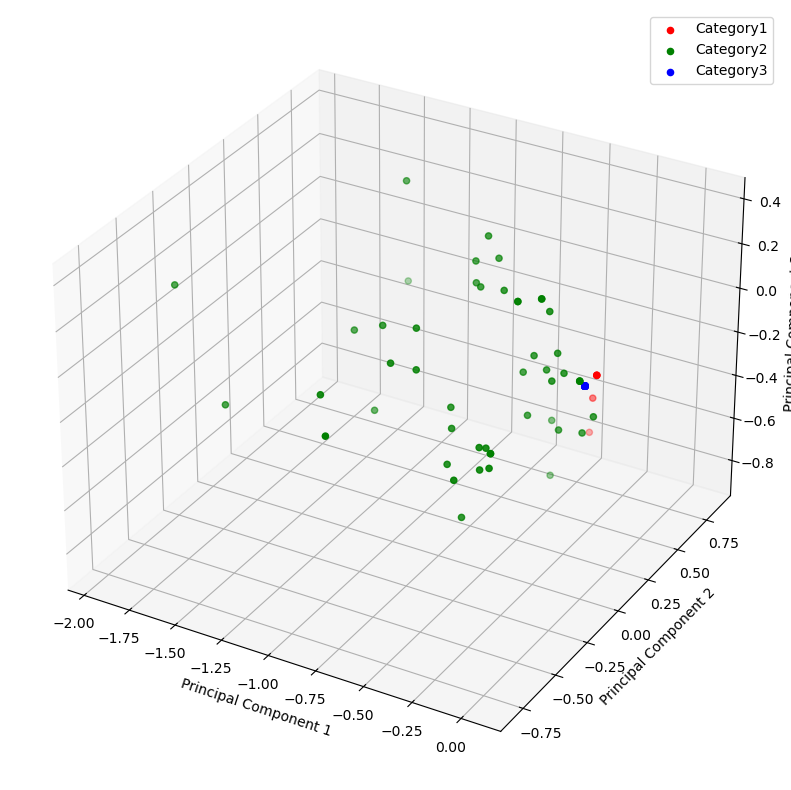

In [58]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lit, last, when
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT

# Helper function to extract elements from vector
def extract_element(vec, i):
    try:
        return float(vec[i])
    except IndexError:
        return None

# Register UDF
extract_element_udf = udf(extract_element, DoubleType())

# Apply the UDF to each element of the vector column
result_pca = result_pca.withColumn('PCA1', extract_element_udf('pcaFeatures', lit(0))) \
                       .withColumn('PCA2', extract_element_udf('pcaFeatures', lit(1))) \
                       .withColumn('PCA3', extract_element_udf('pcaFeatures', lit(2)))

result_pca = result_pca.withColumn('Category', 
                                   when(result_pca['PCA1'] > 0, 'Category1')
                                   .when(result_pca['PCA1'] < 0, 'Category2')
                                   .otherwise('Category3'))

# Collect the data to the driver node (be cautious with large datasets)
pca_pd = result_pca.select('PATNO', 'PCA1', 'PCA2', 'PCA3', 'Category').toPandas()


# Plot the PCA components
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# Plotting (assuming you have already started a matplotlib 3D plot)
colors = {'Category1': 'r', 'Category2': 'g', 'Category3': 'b'}
for category, color in colors.items():
    subset = pca_pd[pca_pd['Category'] == category]
    ax.scatter(subset['PCA1'], subset['PCA2'], subset['PCA3'], c=color, label=category)



ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()

# Splitting Data for Optuna Training

In [60]:
# Join db_minmax with the label data from merged_data
db_selected_labled = db_minmax.join(merged_data["info"].select("PATNO", "ENROLL_CAT"), on="PATNO", how="inner")

# Show the first few rows to verify the results
db_selected_labled.show(3)

24/05/06 19:53:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:53:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:53:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:53:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:53:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 19:53:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-----+---------+----------+----------+------------------+----------+---------+------------------+-----------+-----------+------------------+-----------+----------+------------------+-----------+-----------+-----------+-----------+----------+------------------+-----------+-----------+-----------+-----------+----------+----------+-----------+-----------+-----------+-----------+----------+----------+-----------+-----------+------------------+-----------+----------+------------------+-----------+------------------+------------------+-----------+----------+------------------+-----------+------------------+------------------+-----------+----------+------------------+-----------+-----------+------------------+-----------+----------+------------------+-----------+-----------+------------------+-----------+----------+------------------+-----------+-----------+-----------+-----------+----------+----------+-----------+-----------+-----------+-----------+----------+----------+-----------+--------

In [66]:
db_selected_labled

DataFrame[PATNO: string, BL_NP1COG: double, BL_NP1HALL: double, BL_NP1DPRS: double, BL_NP1ANXS: double, BL_NP1APAT: double, BL_NP1DDS: double, V01_NP1COG: double, V01_NP1HALL: double, V01_NP1DPRS: double, V01_NP1ANXS: double, V01_NP1APAT: double, V01_NP1DDS: double, V02_NP1COG: double, V02_NP1HALL: double, V02_NP1DPRS: double, V02_NP1ANXS: double, V02_NP1APAT: double, V02_NP1DDS: double, V03_NP1COG: double, V03_NP1HALL: double, V03_NP1DPRS: double, V03_NP1ANXS: double, V03_NP1APAT: double, V03_NP1DDS: double, V04_NP1COG: double, V04_NP1HALL: double, V04_NP1DPRS: double, V04_NP1ANXS: double, V04_NP1APAT: double, V04_NP1DDS: double, V05_NP1COG: double, V05_NP1HALL: double, V05_NP1DPRS: double, V05_NP1ANXS: double, V05_NP1APAT: double, V05_NP1DDS: double, V06_NP1COG: double, V06_NP1HALL: double, V06_NP1DPRS: double, V06_NP1ANXS: double, V06_NP1APAT: double, V06_NP1DDS: double, V07_NP1COG: double, V07_NP1HALL: double, V07_NP1DPRS: double, V07_NP1ANXS: double, V07_NP1APAT: double, V07_NP1DD

In [82]:
from pyspark.sql.functions import col, when

# Assuming db_selected_labled is already joined with db_selected with necessary columns
hc_labels = db_selected_labled.filter(col("ENROLL_CAT") == "HC").select("PATNO", "ENROLL_CAT")
pd_labels = db_selected_labled.filter(col("ENROLL_CAT") == "PD").select("PATNO", "ENROLL_CAT")
# Assuming db_selected_labled contains 'PATNO', 'ENROLL_CAT', and all needed features
hc_pd_labels = db_selected_labled.filter(col("ENROLL_CAT").isin("HC", "PD"))



In [78]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

selected_columns = [
    'BL_NP1COG', 'BL_NP1HALL', 'V01_NP1COG', 'V01_NP1HALL', 'V02_NP1COG', 'V02_NP1HALL',
    'V03_NP1COG', 'V03_NP1HALL', 'V04_NP1COG', 'V04_NP1HALL', 'V05_NP1COG', 'V05_NP1HALL',
    'V06_NP1COG', 'V06_NP1HALL', 'V07_NP1COG', 'V07_NP1HALL'
]


# Assembling the vector
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features",
    handleInvalid="skip")
features_df = assembler.transform(hc_pd_labels)

# Fit the KMeans model
kmeans = KMeans().setK(3).setSeed(10).setFeaturesCol("features")
model = kmeans.fit(features_df)

# Make predictions
predictions = model.transform(features_df)

# Add predictions back to the original DataFrame
hc_pd_labels = hc_pd_labels.join(predictions.select("PATNO", "prediction"), "PATNO")

24/05/06 20:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 20:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 20:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 20:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 20:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 20:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 2

# HyperParameter Optimisation

In [ ]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import VectorAssembler

selected_columns = [
    'BL_NP1COG', 'BL_NP1HALL', 'V01_NP1COG', 'V01_NP1HALL', 'V02_NP1COG', 'V02_NP1HALL',
    'V03_NP1COG', 'V03_NP1HALL', 'V04_NP1COG', 'V04_NP1HALL', 'V05_NP1COG', 'V05_NP1HALL',
    'V06_NP1COG', 'V06_NP1HALL', 'V07_NP1COG', 'V07_NP1HALL'
]

# Assembling the vector
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features", handleInvalid="skip")
features_df = assembler.transform(hc_pd_labels)

# Fit the Gaussian Mixture Model
gmm = GaussianMixture().setK(3).setSeed(10).setFeaturesCol("features")
model = gmm.fit(features_df)

# Make predictions
predictions = model.transform(features_df)

# Add predictions back to the original DataFrame
hc_pd_labels = hc_pd_labels.join(predictions.select("PATNO", "prediction"), "PATNO")

In [85]:
hc_pd_labels

DataFrame[PATNO: string, BL_NP1COG: double, BL_NP1HALL: double, BL_NP1DPRS: double, BL_NP1ANXS: double, BL_NP1APAT: double, BL_NP1DDS: double, V01_NP1COG: double, V01_NP1HALL: double, V01_NP1DPRS: double, V01_NP1ANXS: double, V01_NP1APAT: double, V01_NP1DDS: double, V02_NP1COG: double, V02_NP1HALL: double, V02_NP1DPRS: double, V02_NP1ANXS: double, V02_NP1APAT: double, V02_NP1DDS: double, V03_NP1COG: double, V03_NP1HALL: double, V03_NP1DPRS: double, V03_NP1ANXS: double, V03_NP1APAT: double, V03_NP1DDS: double, V04_NP1COG: double, V04_NP1HALL: double, V04_NP1DPRS: double, V04_NP1ANXS: double, V04_NP1APAT: double, V04_NP1DDS: double, V05_NP1COG: double, V05_NP1HALL: double, V05_NP1DPRS: double, V05_NP1ANXS: double, V05_NP1APAT: double, V05_NP1DDS: double, V06_NP1COG: double, V06_NP1HALL: double, V06_NP1DPRS: double, V06_NP1ANXS: double, V06_NP1APAT: double, V06_NP1DDS: double, V07_NP1COG: double, V07_NP1HALL: double, V07_NP1DPRS: double, V07_NP1ANXS: double, V07_NP1APAT: double, V07_NP1DD

#### Step 1: Splitting Dataset into Train and Test data

In [ ]:
from pyspark.sql.functions import col, monotonically_increasing_id
from pyspark.ml.feature import StringIndexer

# Assuming 'hc_pd_labels' is your DataFrame that includes the 'GMM' column with labels
# First, we need to encode the categorical labels 'GMM' into numeric form
indexer = StringIndexer(inputCol="prediction", outputCol="label")
hc_pd_labels = indexer.fit(hc_pd_labels).transform(hc_pd_labels)

# Selecting the specific feature columns and converting them into a feature vector if not already done
selected_features = [c for c in hc_pd_labels.columns if 'BL' in c]  # Adjust according to actual feature names
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
data = assembler.transform(hc_pd_labels)

# Add a unique ID column for splitting
data = data.withColumn("id", monotonically_increasing_id())

# Splitting the data into train and test sets
train = data.filter(col("id") % 5 != 0)  # For 80% training data
test = data.filter(col("id") % 5 == 0)   # For 20% testing data


In [ ]:
X= train.toPandas()

In [ ]:
Y= test.toPandas()

#### Step 2: Training Classification Models

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [55]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [41]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [42]:
# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
# Define the objective function for each classifier
def objective(trial, classifier_name):
    if classifier_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50, log=True)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif classifier_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    elif classifier_name == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

#### Step 3: Model Performance Comparision

In [44]:
# Define the objective function for each classifier
def objective(trial, classifier_name):
    if classifier_name == 'Nearest Neighbors':
        n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif classifier_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        model = DecisionTreeClassifier(max_depth=max_depth)
    elif classifier_name == 'Random Forest Classifier':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif classifier_name == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)
        model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    elif classifier_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [45]:
# Optimization for each classifier
study_results = {}
for classifier in ['Nearest Neighbors', 'Decision Tree', 'Random Forest Classifier', 'AdaBoost', 'XGBoost']:
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, classifier), n_trials=50)
    study_results[classifier] = study

[I 2024-04-28 21:32:29,052] A new study created in memory with name: no-name-4cab23ba-70ca-499b-b9ee-5dffab2e0bd7
[I 2024-04-28 21:32:29,090] Trial 0 finished with value: 0.784 and parameters: {'n_neighbors': 13}. Best is trial 0 with value: 0.784.
[I 2024-04-28 21:32:29,103] Trial 1 finished with value: 0.78 and parameters: {'n_neighbors': 14}. Best is trial 0 with value: 0.784.
[I 2024-04-28 21:32:29,114] Trial 2 finished with value: 0.808 and parameters: {'n_neighbors': 3}. Best is trial 2 with value: 0.808.
[I 2024-04-28 21:32:29,127] Trial 3 finished with value: 0.812 and parameters: {'n_neighbors': 11}. Best is trial 3 with value: 0.812.
[I 2024-04-28 21:32:29,139] Trial 4 finished with value: 0.788 and parameters: {'n_neighbors': 15}. Best is trial 3 with value: 0.812.
[I 2024-04-28 21:32:29,150] Trial 5 finished with value: 0.796 and parameters: {'n_neighbors': 8}. Best is trial 3 with value: 0.812.
[I 2024-04-28 21:32:29,162] Trial 6 finished with value: 0.8 and parameters: {'

In [47]:
# Evaluate and compare models
accuracies = {}
best_estimators = {}
for classifier, study in study_results.items():
    best_params = study.best_trial.params
    if classifier == 'Nearest Neighbors':
        model = KNeighborsClassifier(**best_params)
    elif classifier == 'Decision Tree':
        model = DecisionTreeClassifier(**best_params)
    elif classifier == 'Random Forest Classifier':
        model = RandomForestClassifier(**best_params)
    elif classifier == 'AdaBoost':
        model = AdaBoostClassifier(**best_params)
    elif classifier == 'XGBoost':
        model = XGBClassifier(**best_params)
    
    model.fit(X_train, y_train)
    best_estimators[classifier] = model
    accuracies[classifier] = study.best_trial.value


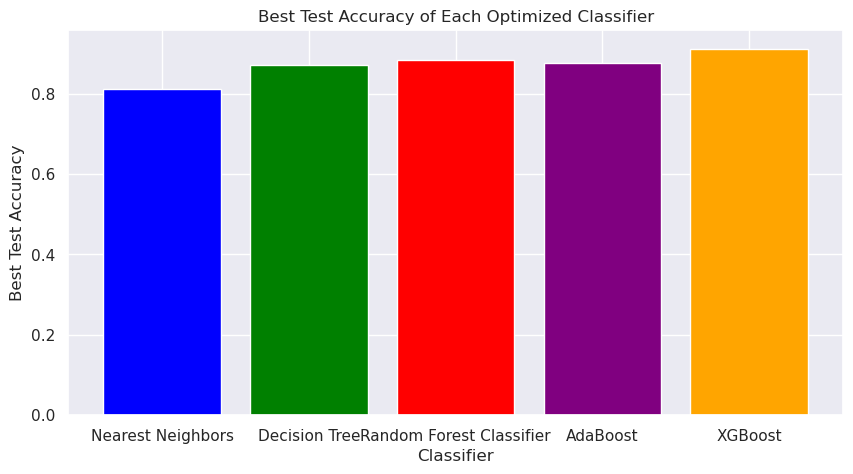

In [48]:
# Define colors for each classifier
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plotting results with different colors for each classifier
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=colors)
plt.xlabel('Classifier')
plt.ylabel('Best Test Accuracy')
plt.title('Best Test Accuracy of Each Optimized Classifier')
plt.show()
